colab link
https://colab.research.google.com/drive/1JnX2pyzHApwAk5umKQkoCWSXV9rkHPU7?usp=sharing

## Import necessary libraries

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import cmath

from itertools import cycle
color_cycle = cycle('cmkbgr')

## Initialize the given parameters and constants

The following general parameters are given 

* no of downsampled samples, $n_s = 27000$
* sampling frequency of the demodulated  continuous data stream, $f = 1080kHz$
* No. of range bins, $C = 30$
* Downsampling rate = 20
* Pulse Repitition Frequency: $f_r = 1800 Hz$
* Horizontal Beam Width $\theta_H = 2^\circ$
* Radar rotation speed $S = 12RPM$
* Speed of Light, $C_s=3\times10^{8}ms^{-1}$
* Radar frequency = $720MHz$


Following parameters are to assign values for targets detected

Object  | Velocity | Threshold | Encode 
--------|----------------------|-----------|-------
Cloud | 50 | 1.05 | 1
Ground Clutter | 0 |-|2
Rain Clutter | 20 | 0.9 |3
Birds | 35 | 1.05 | 4
Air-Crafts | 150 | 0.5 | 5
No object | - | - | 0

In [60]:
# given data

demodulated_sampling_freq = 1080*1000
downsample_rate = 20
range_bins = 30
Pulse_rep_freq = 1800
horiz_beam_width = 2
radar_rotation_speed = 12
speed_of_light = 3e8
radar_freq = 720e6

# assigned values for objects detected
no_object = 0
cloud = 1
ground_clutter = 2
rain_clutter = 3
birds = 4
air_craft = 5

## load data files

In [80]:
real_data = pd.read_csv('/content/real_component.csv', header = None, squeeze=True)
img_data = pd.read_csv('/content/imag_component.csv', header = None, squeeze=True)

#Question 1


$\begin{aligned}\\
starting\, from\, I(t), \\
θ(t) &= 2\pi f_dt-\pi \\
I(t) &= A(t)cos(θ(t))\\
\\
ADC\,conversion \\
t &= nT_s ;\, where\, T_s\, is\, the\, sampling\, period \\
I_0[n] &=A(nT_s) cos(2\pi f_dnT_s - \pi)\\
\\
Impulse\, response, h[n] &= δ[n] - 4δ[n-1] + δ[n-2] \\
MTI\, Cancellation, I[n] &= I_0[n] * h[n] \\
&= I_0[n] -4 I_0[n-1] + I_0[n-2] \\
let\, k&= 2\pi f_dT_s\\
 I[n]&= A(nT_s) cos(kn - \pi) - 4A((n-1)T_s) cos(k(n-1) - \pi) + A((n-2)T_s) cos(k(n-2) - \pi) \\
\\
As\, A(t)\, can\, be\, assumed\, to\, be\, same\, for\, 3\, consecutive\, samples \\ & A(nT_s) ≃ A((n-1)T_s) ≃ A((n-2)T_s) => A(nT_s)\\
I[n] &= A[n] [cos(kn - \pi) - 4 cos(k(n-1) - \pi) + cos(k(n-2) - \pi)] \\
&= A[n][- 4 cos(k(n-1) - \pi) + 2cos(k(n-1) - \pi) cos(k)] \\
&= 2A[n]cos(k(n-1) - \pi)(cos(k) - 2) \\
&= -2A[n]cos(k(n-1)- \pi)(1 + sin^2(k/2)) \\
&= 2A[n]cos(k(n-1))(1 + sin^2(k/2)) \\
\\
Downsampling\\
since, \,the\, beginning\, of\, the\, downsampling\, starts\, from\, the\, mid\, point\, (10^{th}), n̂&= 20n + 10 \\
I[n̂] &= 2A[(20n̂+10)T_s] cos(2\pi f_d T_s(20n̂ + 10 -1))[1+sin^2(2\pi f_d T_s/2)]\\
assuming, \, T_s << 1\, and\, f_d \,being \,few\, hundreds \,of \,Hz, \\
sin^2(2\pi f_d T_s/2) ≃ 0 \\
\therefore I[n] &= 2A[(20n+10)T_s] cos(2\pi f_d T_s(20n + 9))\\
\\
similarly, 
Q[n] &= 2A[(20n+10)T_s] sin(2\pi f_d T_s(20n + 9))
\\
ω[n] &= I[n] + jQ[n] \\
&= 2A[(20n+10)T_s] cos(2\pi f_d T_s(20n + 9)) + j2A[(20n+10)T_s] sin(2\pi f_d T_s(20n + 9))\\
 ω[n] &= 2A[(20n+10)T_s] e^{j2\pi f_d T_s(20n + 9)}
\end{aligned}$


## Obtain the radar matrix


* Initial samples are taken at a very high sampling rate ($f$) to give the essence of a continuous signal. Therefore the task would be to to fit into required range bins ($N$). 
* Let's find out how many echo pulses are included in a given dataset.
* Initial no of samples = $27000*20=540K$
* The total time covered by the dataset is obtained by dividing the no of samples by sampling frequency.
  >$T = \frac{n_s}{f} = \frac{27000 \times 20}{1080 \times 10^3} = 0.5 s$
* Since we know the speed of the radar rotation, we can find the angle in degrees covered by the received data. 
>$\theta = \frac{S \times T \times 360^{\circ}}{60} = 36^{\circ}$
*  With this data, now we can find the no of echoes received while sweeping across for  $36^{\circ}$. 
>no echoes, $ N = f_r \times T = 900$ 
* $\therefore  \frac{27000}{900} = 30 \text{ samples}$ represent one echo in downsampled dataset! 
* Hence, this represent the number of range bins one echo is divided into.

* $\therefore$ The size of the data matrix would be, $N \times C : (900 \times 30)$


### **Assumptions**
  * Assume the data set starts from an the beginning of an echo pulse.

  * Assume the data set contains exactly the amount of data for a whole number of pulses. 


In [81]:
complex_sequence = (real_data + 1j * img_data).to_numpy() #complex sequence
total_sampled_echoes = len(complex_sequence) 
no_pulses = int(total_sampled_echoes/range_bins)

data_matrix = complex_sequence.reshape(no_pulses, range_bins) #initial data matrix

### Amplitude and phase graphs of the radar matrix

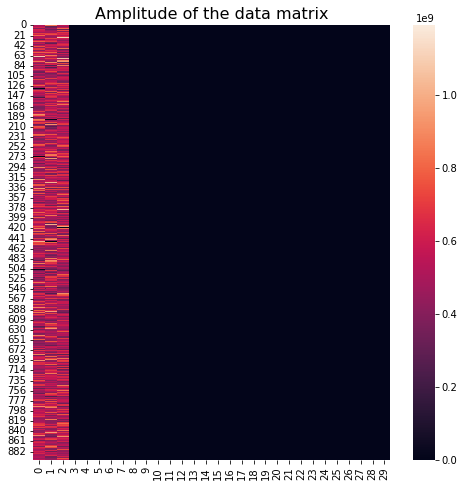

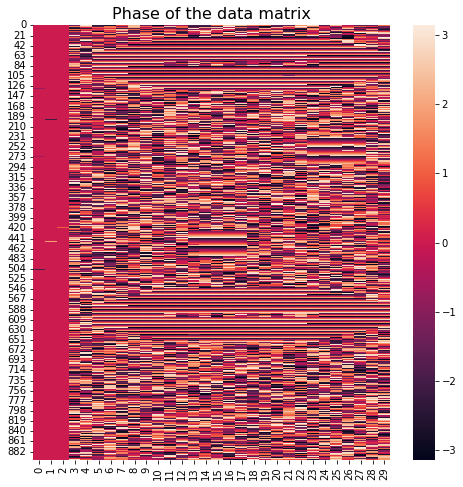

In [82]:
#amplitude calculation
amplitude = abs(data_matrix)

plt.subplots(figsize=(8,8))
plt.title(label = "Amplitude of the data matrix", fontsize = 16)
sns.heatmap(amplitude, cbar=True)

#phase calculation
phase_func = np.vectorize(lambda x : cmath.phase(x))
phase = phase_func(data_matrix)

plt.subplots(figsize=(8,8))
plt.title(label = "Phase of the data matrix", fontsize = 16)
sns.heatmap(phase, cbar=True)

As we can see, the first 3 range bins contain very high amplitudes with roughly zero phase angle. This is a high possiblity of a ground clutter. 
Lets plot to differentiate these patterns. 

# Question 2
## Ground Clutter analysis and removal

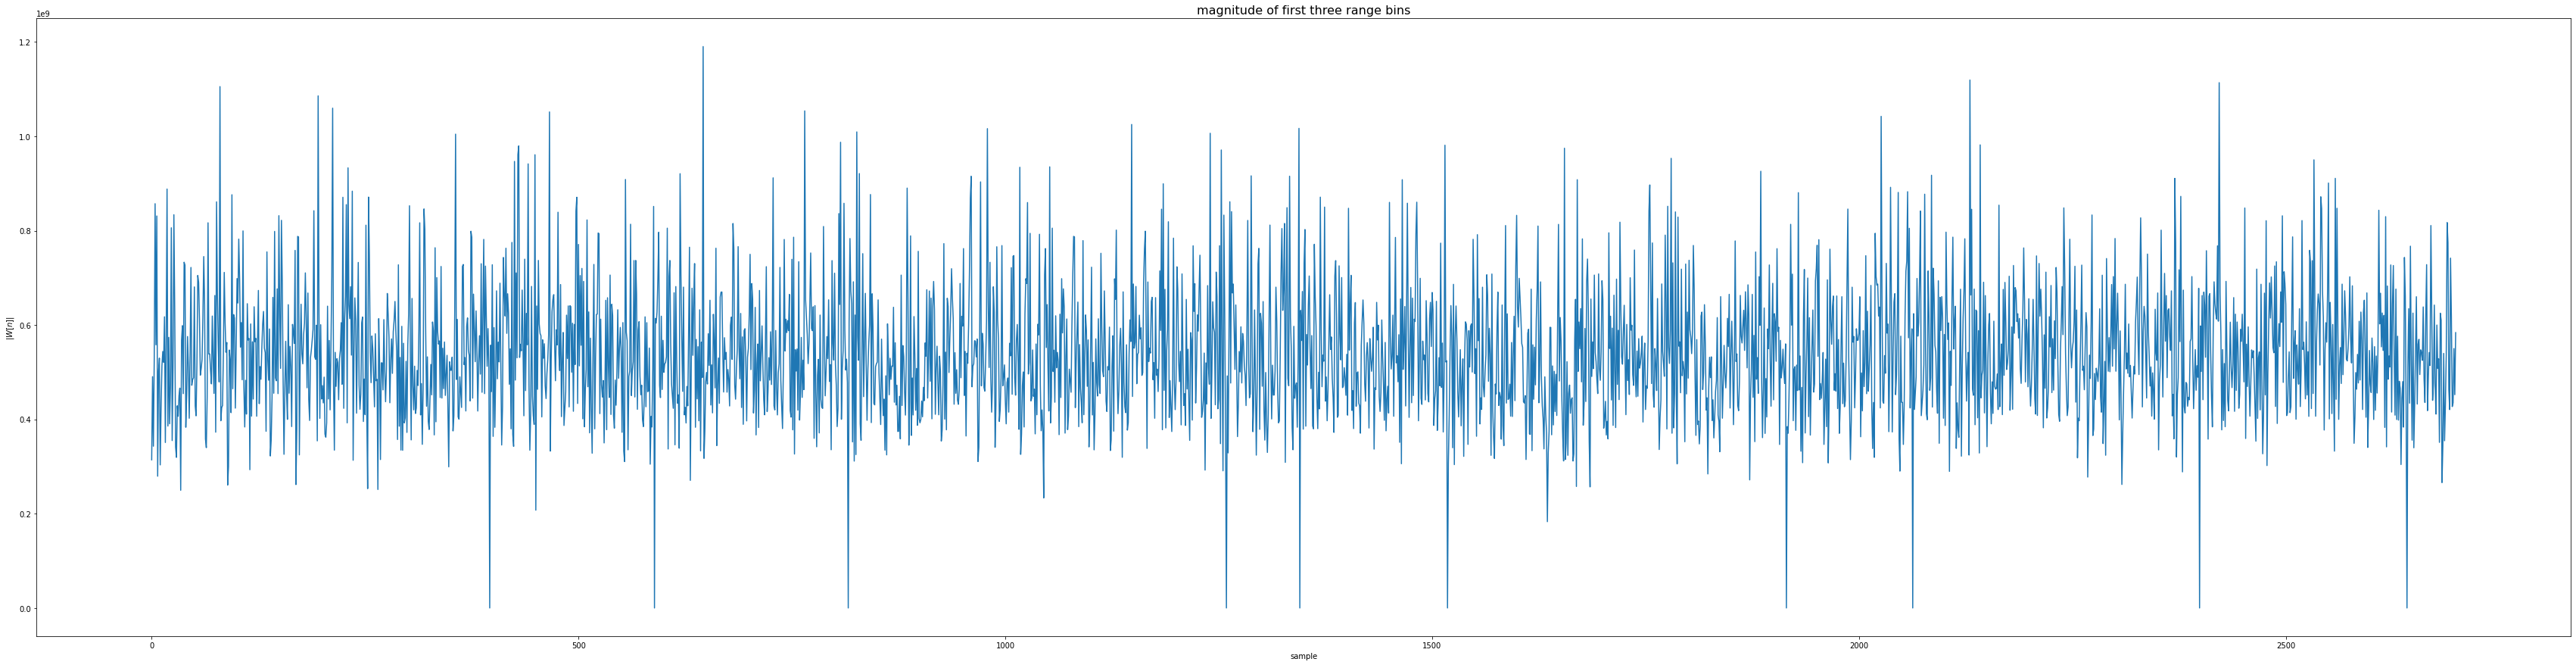

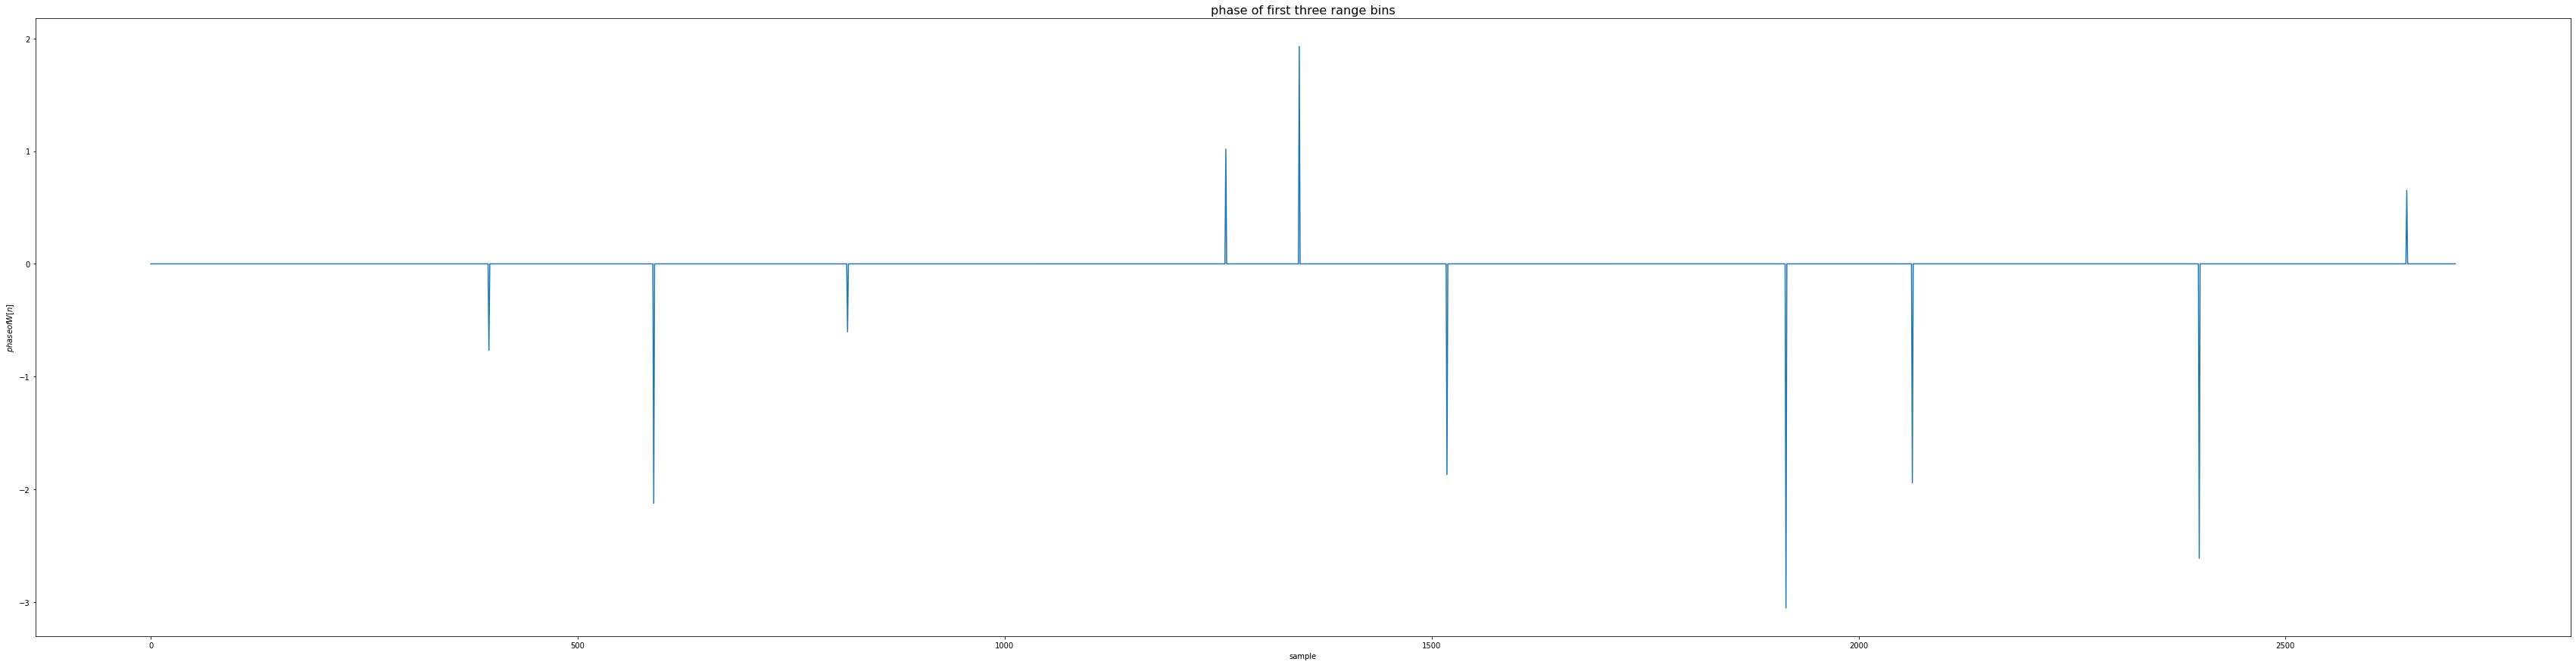

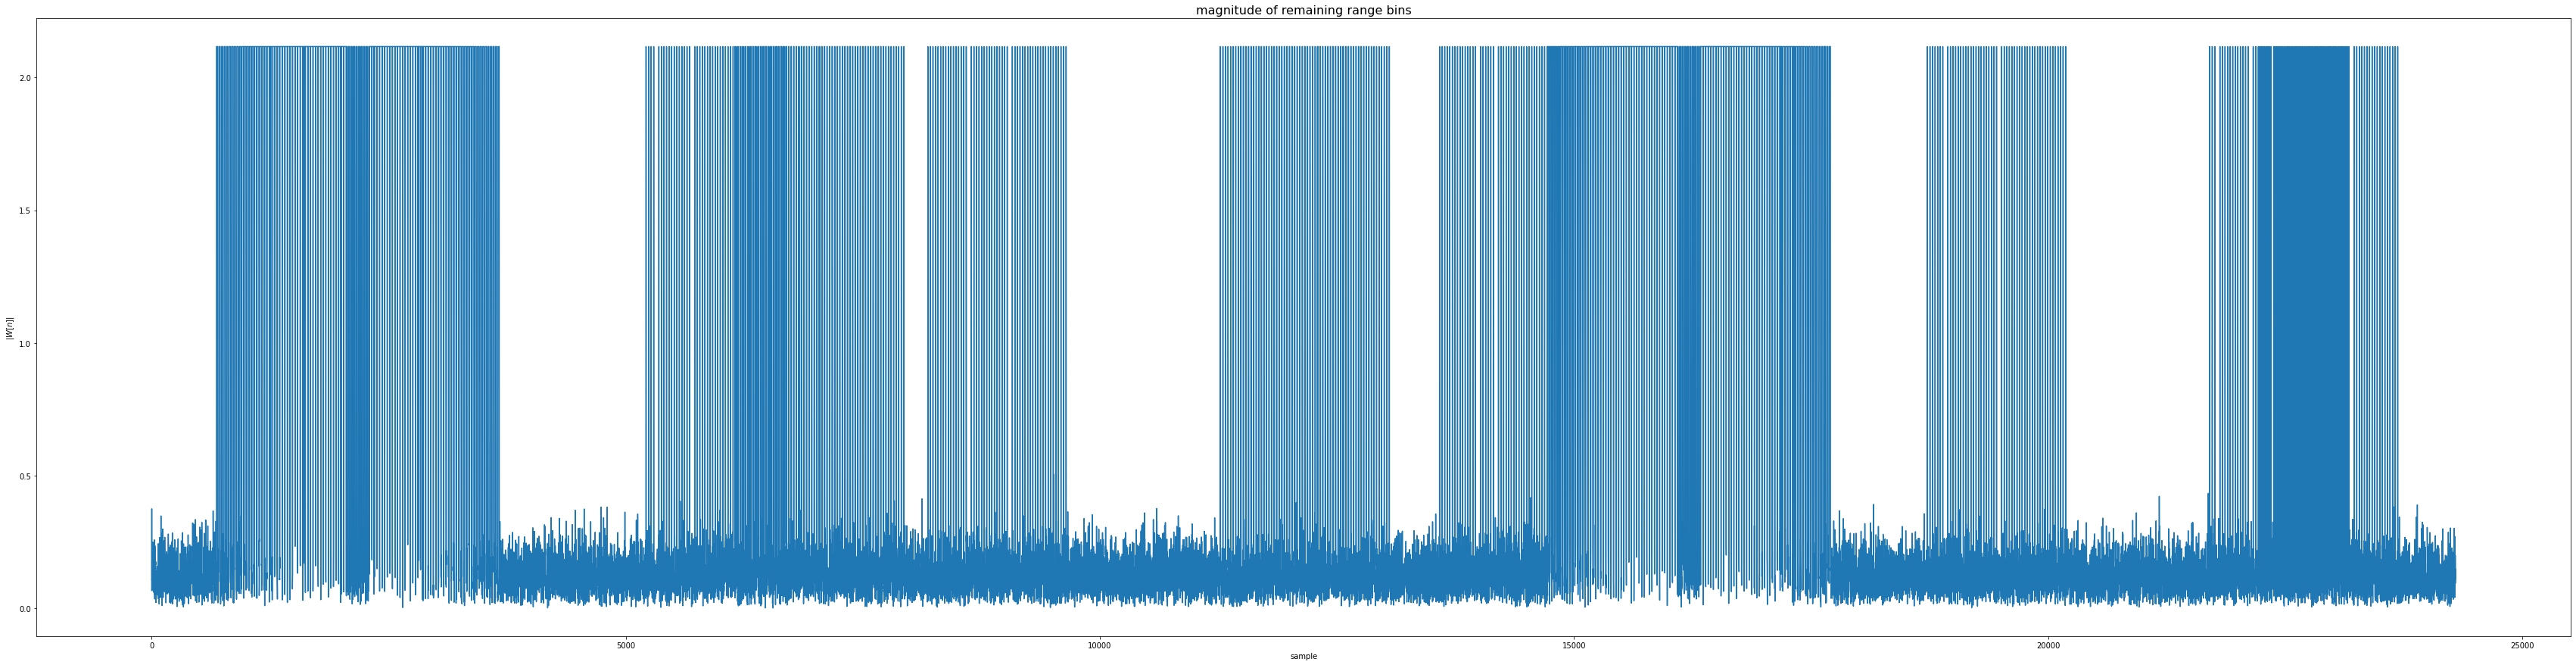

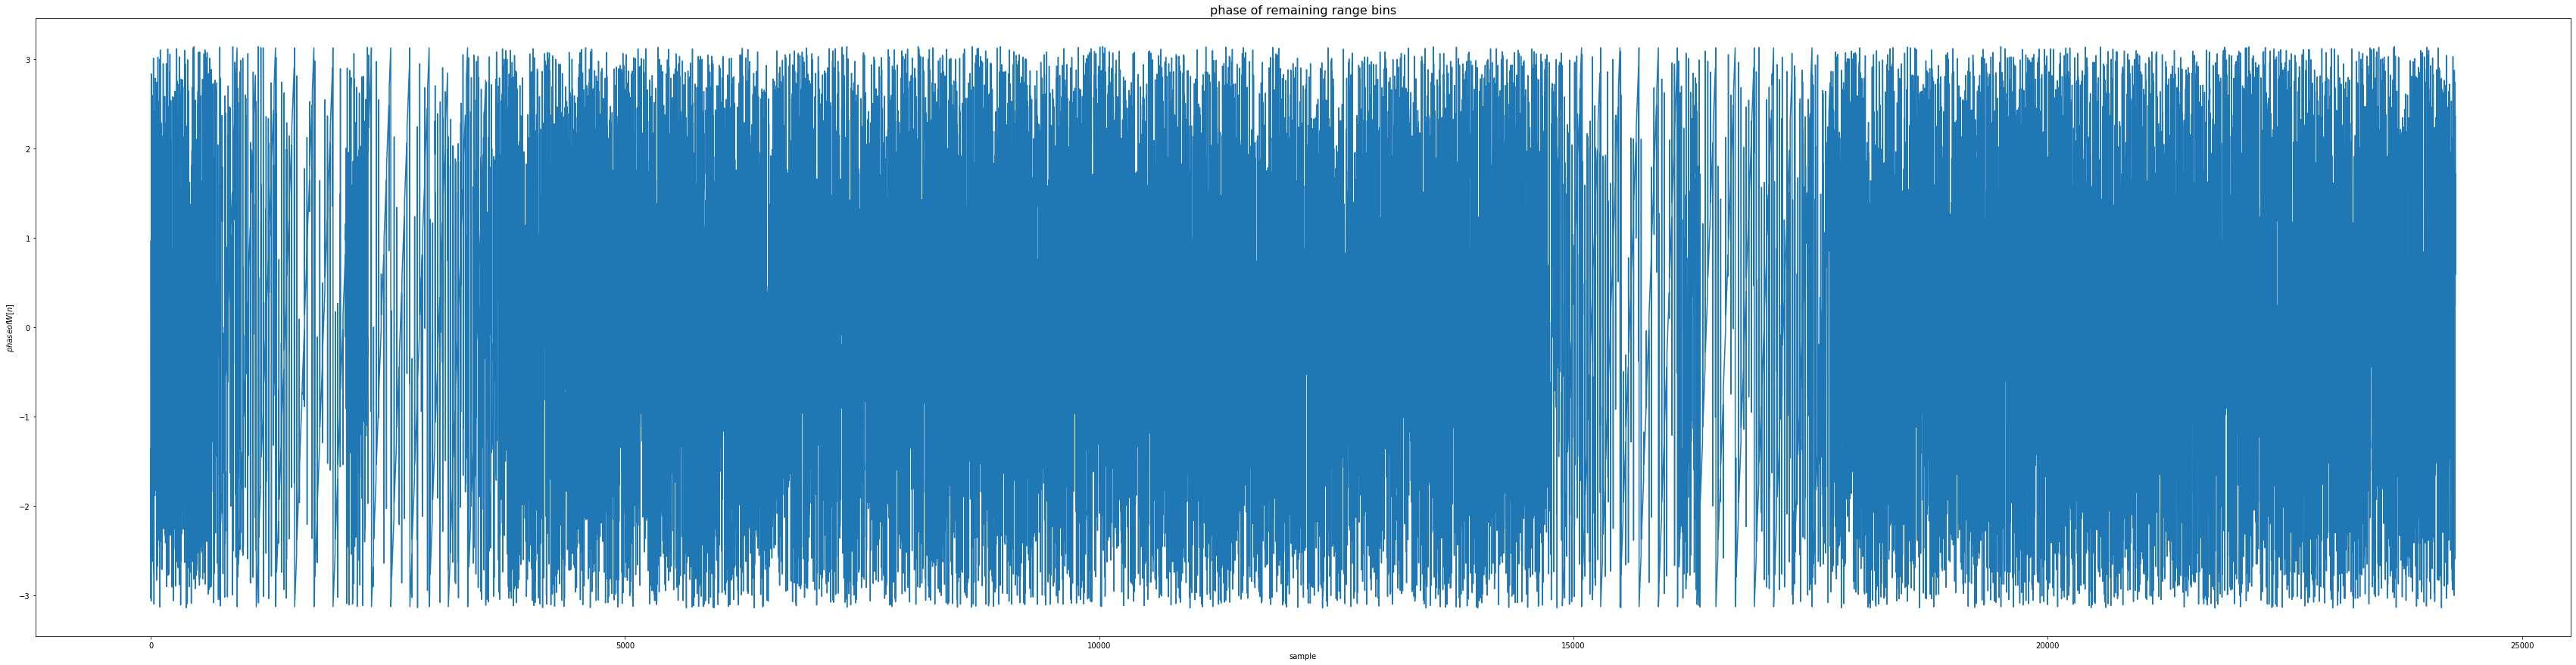

In [83]:

dc_bins = amplitude[:,:3].flatten()
other_bins = amplitude[:,3:].flatten()

dc_phase = phase[:, :3].flatten()
other_phase = phase[:, 3:].flatten()

plt.subplots(figsize=(60, 15))
plt.ylabel('$|W[n]|$')
plt.xlabel('sample')
plt.title('magnitude of first three range bins', fontsize = 16)
plt.plot(dc_bins)

plt.subplots(figsize=(60, 15))
plt.ylabel('$phase of W[n]$')
plt.xlabel('sample')
plt.title('phase of first three range bins', fontsize = 16)
plt.plot(dc_phase)

plt.subplots(figsize=(60, 15))
plt.ylabel('$|W[n]|$')
plt.xlabel('sample')
plt.title('magnitude of remaining range bins', fontsize = 16)
plt.plot(other_bins)

plt.subplots(figsize=(60, 15))
plt.ylabel('$phase of W[n]$')
plt.xlabel('sample')
plt.title('phase of remaining range bins', fontsize = 16)
plt.plot(other_phase)

according to the derived equation under Q1 and above graphical data, the best way to remove the ground clutter would be to remove data points which have close to zero phase. \\
According to the equation, \\
 $ω[n] = 2A[(20n+10)T_s] e^{2\pi f_d T_s(20n + 9)}$ \\
 * object velocity is directly proportional to doppler frequency.  
 * doppler frequency is directrly proportional to phase changes. 
 * $\therefore$ f_d ≃ 0 gives details about static objects. 
 * hence, to remove ground clutter from the signal, apply a binary threshold algorithm as the Zero Velocity Filter (ZVF) to the phase of the complex data cells. 

#Question 3

## Zero Velocity Filter

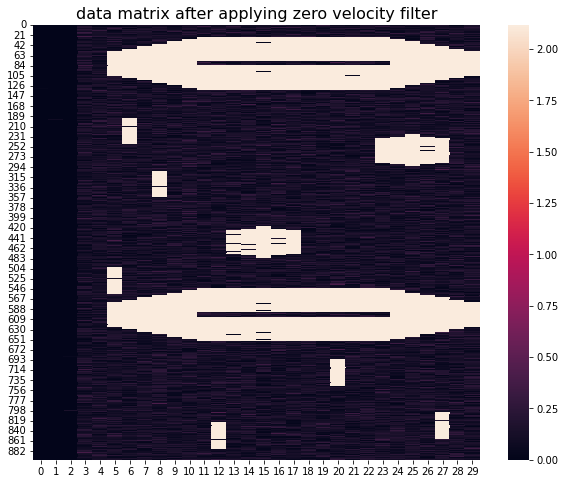

In [84]:
ground_thresh = 1e-3  #lower DC value for ground thresholding

ground_filtered_matrix = np.where(abs(phase)<ground_thresh, 0, data_matrix)
ground_encoded_matrix = np.where(abs(phase)<ground_thresh,2,0)
plt.figure(figsize=(10, 8))
plt.title(label = "data matrix after applying zero velocity filter", fontsize = 16)
plt.xlabel('range slot')
plt.ylabel('transmit pulse number')
sns.heatmap(abs(ground_filtered_matrix), cbar=True)

### range bin analysis after applying ZVF

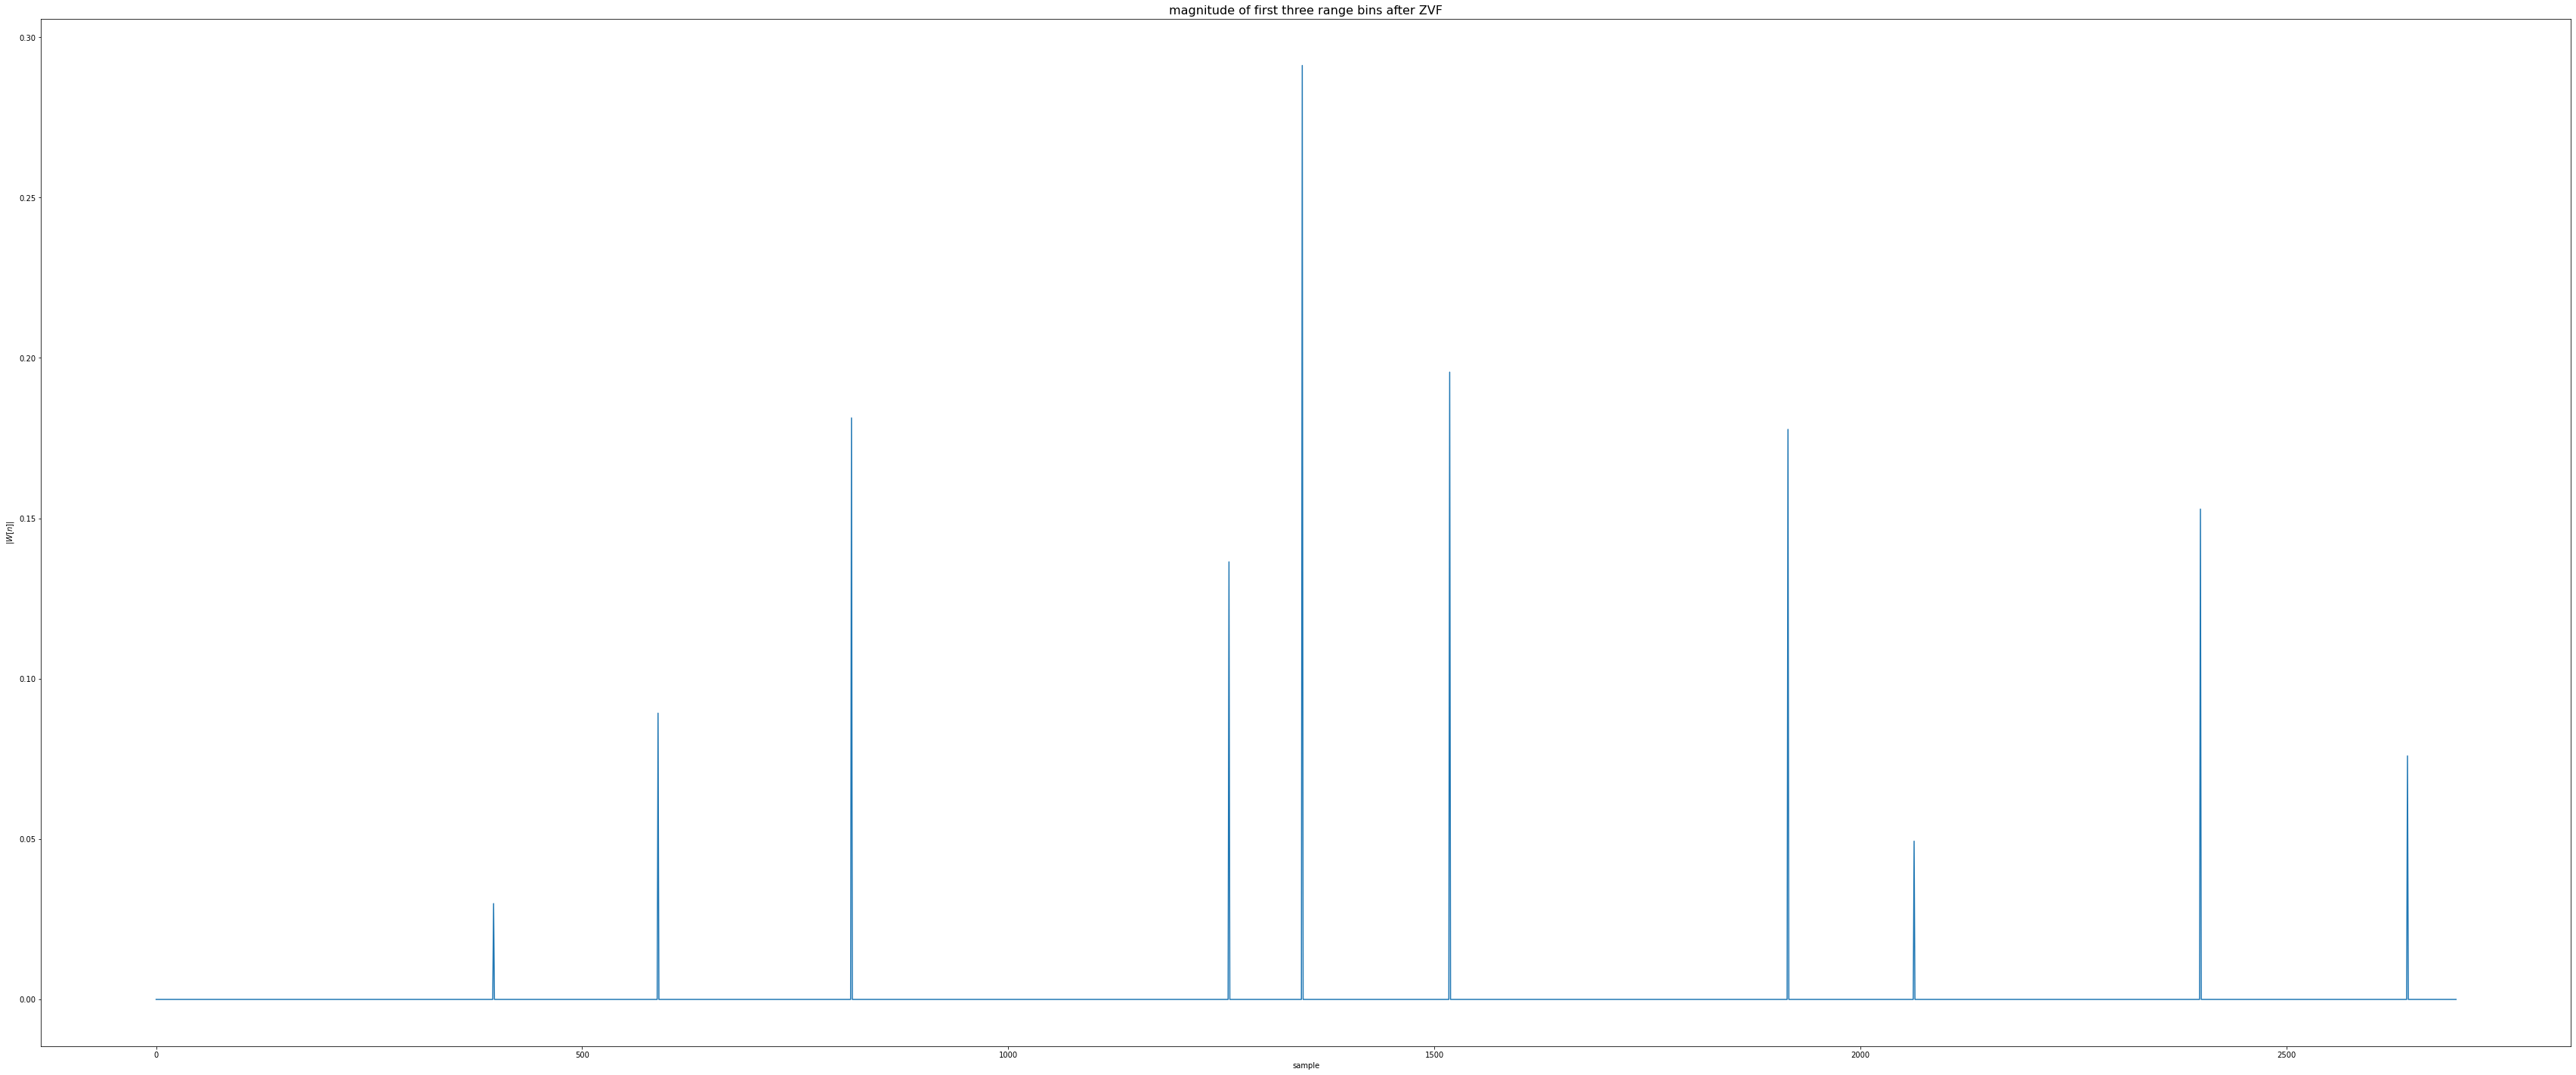

In [85]:
plt.figure(figsize=(60, 25))
plt.ylabel('$|W[n]|$')
plt.xlabel('sample') 
plt.title('magnitude of first three range bins after ZVF', fontsize = 16)
plt.plot(abs(ground_filtered_matrix)[:,:3].flatten())

As we can see, all the large amplitude valued ground clutters are removed from the dataset. 

# Question 4

obtaining the doppler frequencies for each object considering it's assumed velocity.

$\begin{aligned}
f_d &= \frac{2V_r}{λ} \\
&= \frac{2V_rf}{c}
\end{aligned}$

In [86]:
objects = {"cloud": [50, 1.05, 1], "ground_clutter":[0, 0, 2], "rain_clutter":[20, 0.9, 3], "birds": [35, 1.05, 4], "aircraft": [150, 0.5, 5]}

for key, item in objects.items():
  velocity = item[0]
  doppler_f = (2*velocity*radar_freq)/speed_of_light
  item.extend([doppler_f])

print(objects)

{'cloud': [50, 1.05, 1, 240.0], 'ground_clutter': [0, 0, 2, 0.0], 'rain_clutter': [20, 0.9, 3, 96.0], 'birds': [35, 1.05, 4, 168.0], 'aircraft': [150, 0.5, 5, 720.0]}


### function to plot the FFT graph

In [87]:
def plot_fft(fft_matrix, objects, F_s, single_bin = 0):

  # plot the magnitude
  fft_abs = np.abs(fft_matrix) 

  # frequency bins
  f_pos = np.arange(start = 0, stop = F_s / 2, step=F_s / no_pulses) 
  f_neg = np.arange(start = -F_s / 2, stop = 0, step=F_s / no_pulses)

  # axis labeling
  plt.figure(figsize=(30, 8))
  ax=plt.ylabel('$|W(f)|$')
  ax=plt.xlabel('Frequency (Hz)')
  ax=plt.title('FFT representation of W[n]')

  # sampling of the x-axis
  ax = plt.xticks(np.arange(-F_s/2, F_s / 2, (F_s*30)/no_pulses))

  # apply colors to bins
  if single_bin:
    col0 = next(color_cycle)
  else:
    col0=None
  plt.plot(f_pos, fft_abs[:(no_pulses // 2)],color=col0)
  plt.plot(f_neg, fft_abs[(no_pulses // 2):],color=col0)


  # draw vertical lines to detect objects
  for keys,items in objects.items():
      frq = items[-1]
      col = next(color_cycle)
      plt.vlines(x=frq,ymin=0,ymax=max(fft_abs.flatten())+50,linestyles='--',colors=col,label=keys)
      plt.vlines(x=-frq,ymin=0,ymax=max(fft_abs.flatten())+50,linestyles='--',colors=col,label=keys)
  
  # plot legends
  handles, labels = plt.gca().get_legend_handles_labels() 
  labels, ids = np.unique(labels, return_index=True)
  handles = [handles[i] for i in ids]
  plt.legend(handles, labels, loc='best')
  plt.show()

### plotting spectrum analyser for selected range bins



(900, 30)


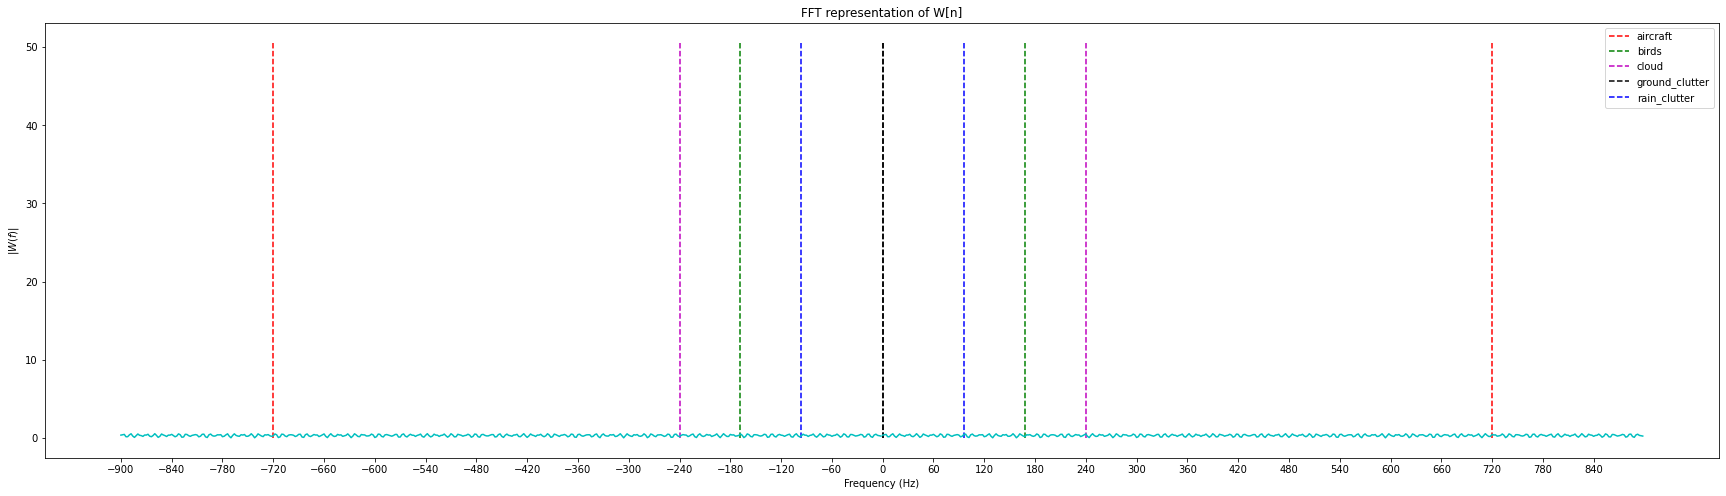

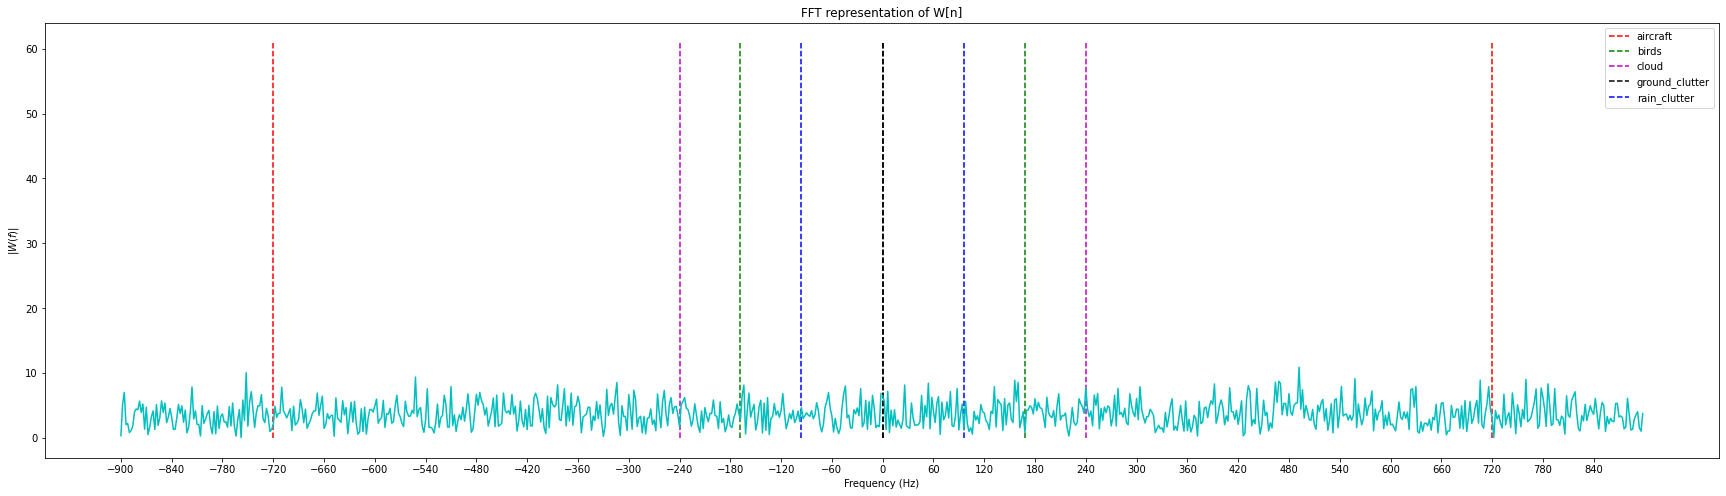

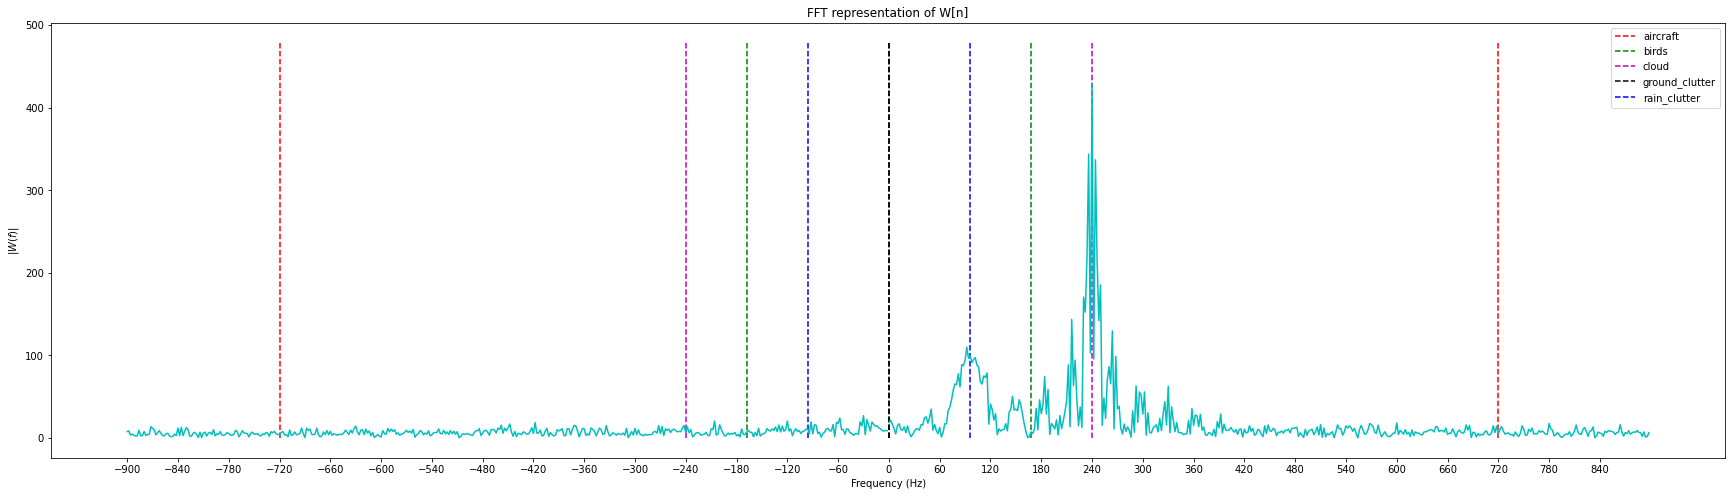

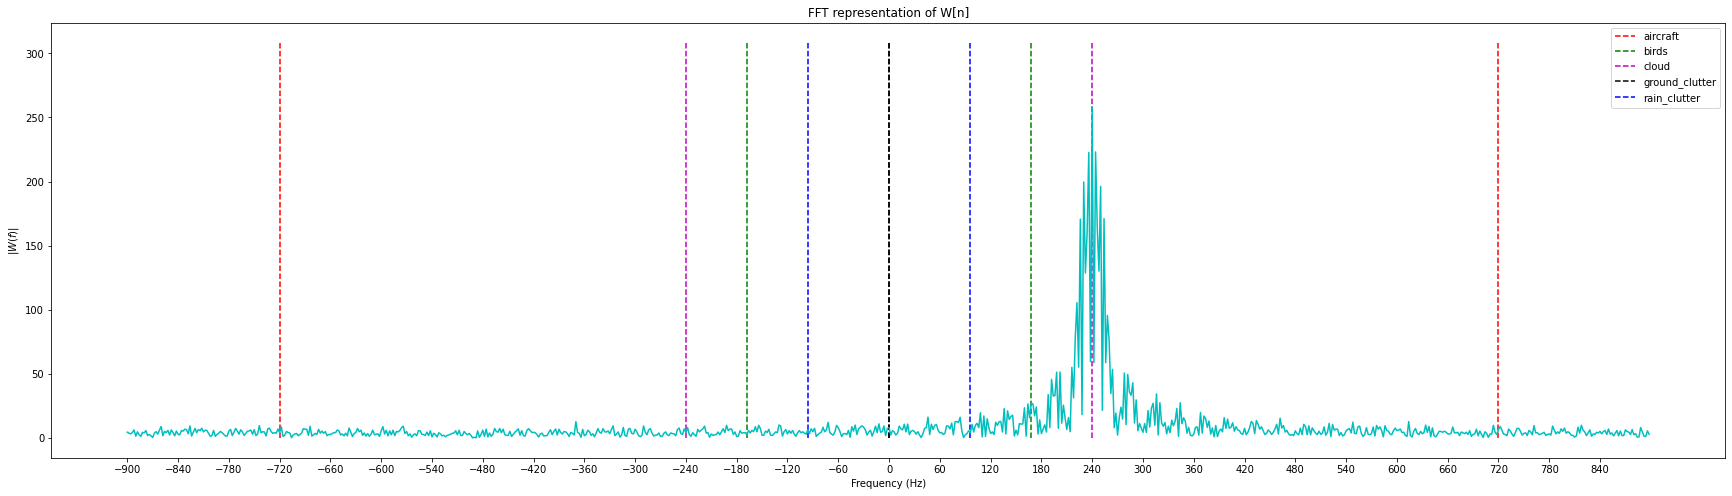

In [88]:
fft_data_matrix = np.fft.fft(ground_filtered_matrix,axis=0)
print(fft_data_matrix.shape)
for i in [1, 4,13, 28]:
  plot_fft(fft_data_matrix[:, i], objects, Pulse_rep_freq, 1)


as visible, for higher range bins, moving objects are detected in a same manner while the power of the echo pulses differ. However due to ground clutter, lower range bins gets a lower amount of moving objects

### Plotting spectrum analyser for all range bins



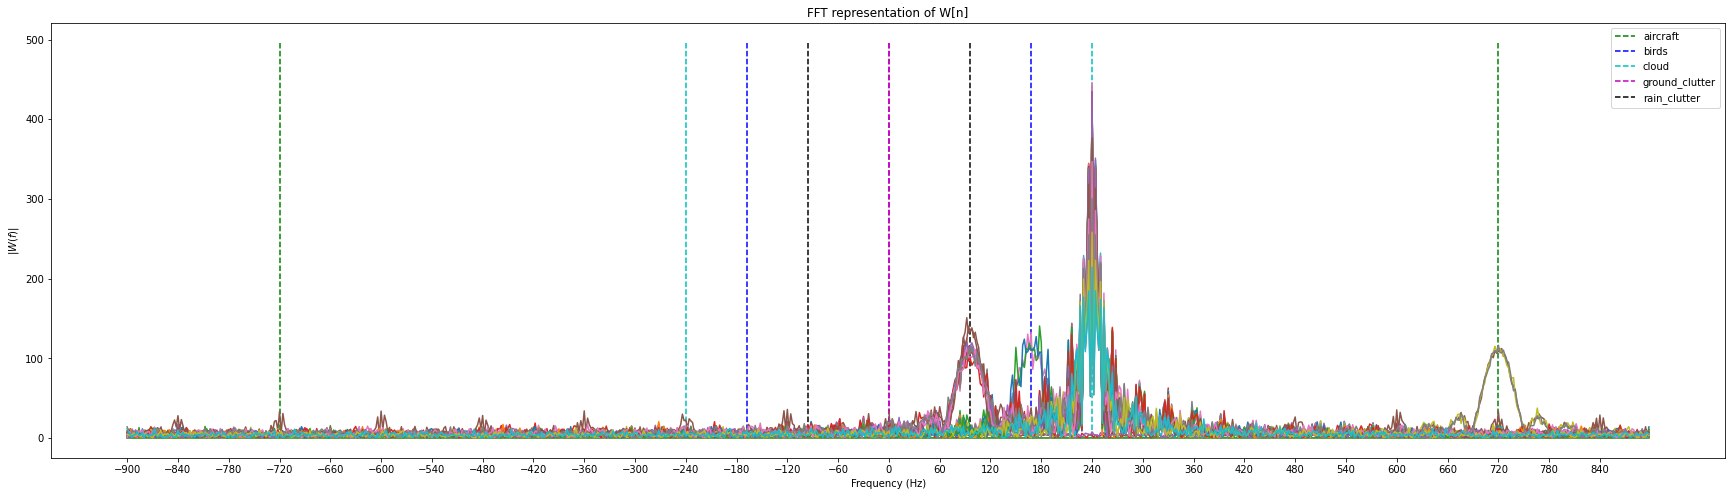

{'cloud': [50, 1.05, 1, 240.0], 'ground_clutter': [0, 0, 2, 0.0], 'rain_clutter': [20, 0.9, 3, 96.0], 'birds': [35, 1.05, 4, 168.0], 'aircraft': [150, 0.5, 5, 720.0]}


In [89]:
plot_fft(fft_data_matrix, objects, Pulse_rep_freq)
print(objects)

### Suitable BW for velocity filters
according to the above plot, most of the moving objects resides in the range of $60-80HZ 
\therefore suitable\, BW\, is\, selected\, as\, 70Hz.$

In [90]:
BW = 70

# Question 05

## function to get a BandPass filter for filter bank




In [91]:
def BandPass_filter(center_f, BW, f_s, N, plot=0):

  # frequency bounds
  low_f = center_f - BW//2
  high_f = center_f + BW//2

  # frequency bins
  f_pos = np.arange(start = 0, stop = f_s / 2, step=f_s / N) 
  f_neg = np.arange(start = -f_s / 2, stop = 0, step=f_s / N) 
  f = np.concatenate([f_neg, f_pos])

  # BPF applying
  H_pos = ((f_pos >= low_f) & (f_pos <= high_f))

  H_neg = 0*((f_pos >= low_f) & (f_pos <= high_f))
  # H_neg = ((f_neg <= -low_f) & (f_neg >= -high_f))
  # H = np.concatenate([H_neg, H_pos])

  H = np.concatenate([H_pos, np.flip(H_neg)]) 
  H = H.reshape(H.shape[0], 1)
  if (plot):
    plt.plot(f, H)

  return H



## *apply* Velocity filter bank

 after obtaining the $w[f]$, the velocity filter bank is applied as follows,
 * for each object, a bandpass filter is obtained, $BPF_i(f)$
 * each of these bandpass filters are passed through $w[f]$
 * $w_i[f] = w[f] * BPF_i(f)$
 * inverse FFT is applied at this point, $w_i[n] = ifft(w_i[f])$
 * this filter will then be go passed into object detection. thresholding and encoding will be performed. 
 * $wth_i[n] = w_i[n] * thresh_i$
 * $wfinal_i[n] = wth_i[n] * encode_i$



In [92]:
for key, item in objects.items():
  if (key != "ground_clutter"):
    center_f = item[3]
    threshold = item[1]
    encode = item[2]
    filter = BandPass_filter(center_f, BW, Pulse_rep_freq, no_pulses) #bandpass filter
    f_filtered_matrix = np.multiply(fft_data_matrix, filter) # apply the filter
    filtered_matrix = np.fft.ifft(f_filtered_matrix, axis = 0) # convert to time domain
    encoded_matrix = (abs(filtered_matrix)>=threshold)*encode # threshold and encode
    item.extend([encoded_matrix])
    np.savetxt(key+".csv", encoded_matrix, delimiter=",")

### function to generate heatmaps for each detected moving object

In [93]:
def generate_heatmap(DataMatrix,dict_label,title):
  f,ax = plt.subplots(figsize=(10,8))
  ax.set_title(title)

  n=len(dict_label)
  cmap = sns.color_palette('tab20', n)
  ax = sns.heatmap(DataMatrix, cmap=cmap)
  colorbar = ax.collections[0].colorbar
  
  r = colorbar.vmax - colorbar.vmin
  colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
  lbl= list(dict_label.keys())

  lbl[0],lbl[1]=lbl[1],lbl[0]
  colorbar.set_ticklabels(lbl)
  

## plot heatmaps for each detected object

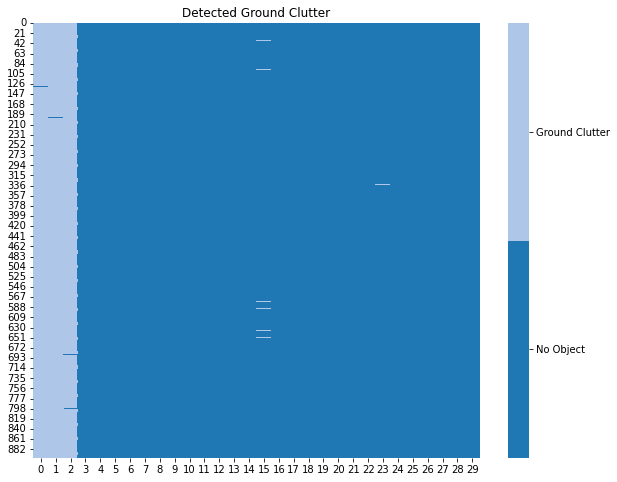

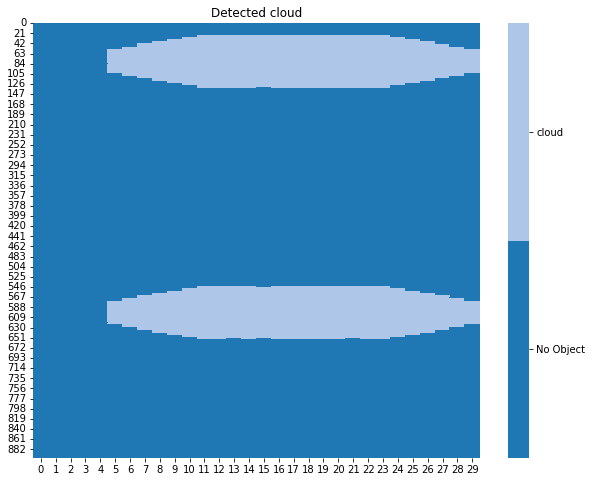

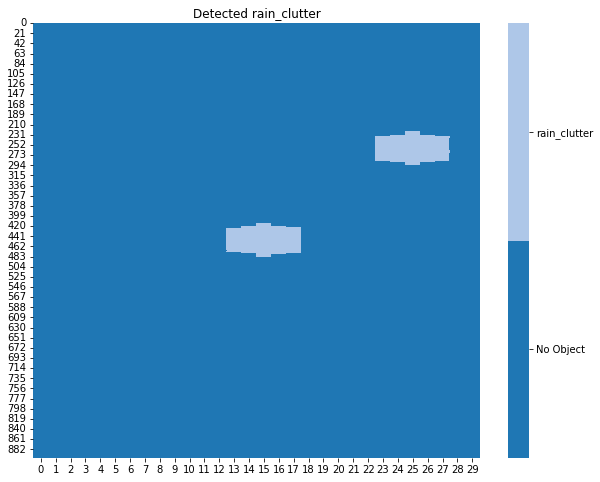

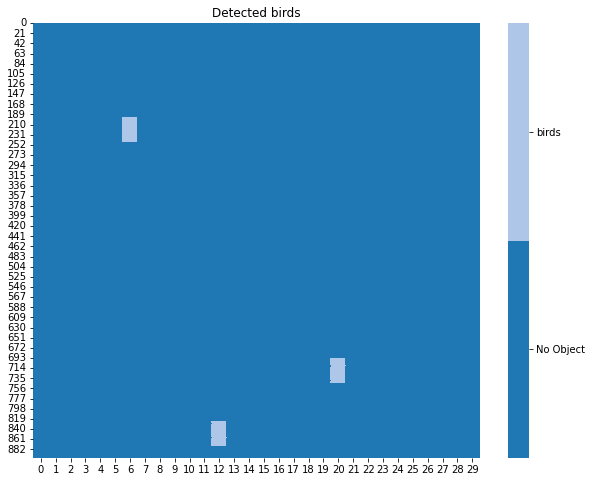

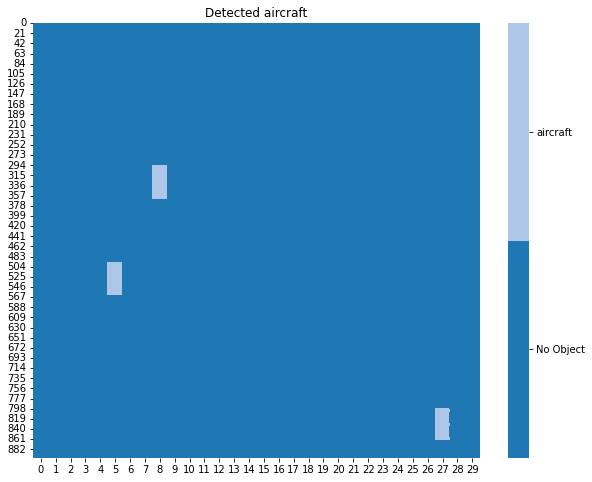

In [94]:
title = 'Detected Ground Clutter'
px= generate_heatmap(ground_encoded_matrix,{'Ground Clutter':1,'No Object':0},title)
np.savetxt("Ground_Clutter.csv", ground_encoded_matrix, delimiter=",") 

final_encoded_matrix = ground_encoded_matrix
for key,vals in objects.items():
  if (key != "ground_clutter"):
    plot_encoded = vals[4]
    final_encoded_matrix +=plot_encoded
    title = 'Detected '+key
    px = generate_heatmap(plot_encoded, {key:vals[2], 'No Object':0}, title)

plot the final data matrix after detecting each moving object and ground clutter

['no object', 'cloud', 'ground_clutter', 'rain_clutter', 'birds', 'aircraft']


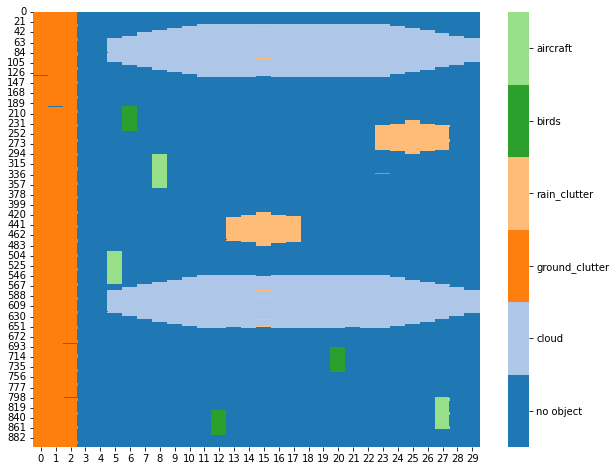

In [98]:
f,ax = plt.subplots(figsize=(10,8))
n=len(objects)+1
cmap = sns.color_palette('tab20', n)  # defining the colour map
ax = sns.heatmap(final_encoded_matrix, cmap=cmap)  # ploting the data matrix with all encoded data
colorbar = ax.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
lbl1=list(objects.keys()) + ['no object']
lbl1.insert(0, lbl1.pop())
print(lbl1)
colorbar.set_ticklabels(lbl1)